# Detecting Anomalous Streams using Signature Variance
## PenDigits Dataset

In [1]:
import os.path
import sys
import time

import iisignature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.utils

sys.path.insert(0, os.path.join('..', 'empirical-outliers'))
import variance
import variance_rp
sys.path.insert(0, os.path.join('..', 'common'))
import evaluation
import util

In [2]:
%matplotlib inline
 
import IPython.display
IPython.display.set_matplotlib_formats('png', 'pdf')

/Users/zhen/Dropbox/ROOT/Work/Anomaly_detection/petersNotebook/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  after removing the cwd from sys.path.


In [3]:
np.random.seed(0)

In [4]:
t0 = time.time()

Download and extract dataset, if it does not already exist:

In [5]:
DATASET_URLS = ['https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits-orig.tes.Z',
                'https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits-orig.tra.Z']

for source_url in DATASET_URLS:
    target_filename = source_url.split('/')[-1]
    if not os.path.exists(target_filename[:-2]):
        try:
            util.download(source_url, target_filename)
            !uncompress {target_filename}
        except:
            if os.path.exists(target_filename):
                os.remove(target_filename)
            raise

Load dataset and create data frame:

In [6]:
data = {'train': util.load_pendigits_dataset('pendigits-orig.tra'),
        'test': util.load_pendigits_dataset('pendigits-orig.tes')}

dataframes = []
for subset, data in data.items():
    df = pd.DataFrame(data).T
    df.columns = ['Stream', 'Digit']
    df['Subset'] = subset
    dataframes.append(df)
df = pd.concat(dataframes)

Obtain summary statistics for the dataset:

In [7]:
mean_corpus_size = df[df['Subset'] == 'train']['Digit'].value_counts().mean()
testing_data_size = len(df[df['Subset'] == 'test'])
mean_outlier_size = testing_data_size - df[df['Subset'] == 'test']['Digit'].value_counts().mean()

print('Mean corpus size: {}'.format(mean_corpus_size))
print('Testing subset size: {}'.format(testing_data_size))
print('Mean testing outlier subset size: {}'.format(mean_outlier_size))

Mean corpus size: 749.4
Testing subset size: 3498
Mean testing outlier subset size: 3148.2


Define a function which takes an input stream and transforms it as specified:

In [8]:
def get_stream(raw_stream, include_time=False, lead_lag_transform=False, invisibility_transform=False):
    stream = raw_stream

    if include_time:
        stream = np.column_stack((stream, np.arange(stream.shape[0])))

    if lead_lag_transform:
        stream = np.repeat(stream, 2, axis=0)
        stream = np.column_stack((stream[1:, :], stream[:-1, :]))

    if invisibility_transform:
        stream = np.vstack(((stream, stream[-1], np.zeros_like(stream[-1]))))
        stream = np.column_stack((stream, np.append(np.ones(stream.shape[0]-2), [0, 0])))

    return stream

Define a function which computes the variance of testing subsets:

In [9]:
def compute_stream_signature_variance(corpus, inlier_test, outlier_test, signature_order, random_state=0):    
    def normalise(streams):
        return [sklearn.preprocessing.MinMaxScaler().fit_transform(stream) for stream in streams]

    corpus, inlier_test, outlier_test = map(normalise, (corpus, inlier_test, outlier_test))

    variance_inliers = np.array(variance.variance(inlier_test, corpus, signature_order))
    variance_outliers = np.array(variance.variance(sklearn.utils.shuffle(outlier_test, random_state=random_state),
                                                   corpus, signature_order))
    
    return variance_inliers, variance_outliers

In [13]:
def compute_stream_signature_variance_rp(corpus, inlier_test, outlier_test, signature_order, random_state=0):
    projection_dim = 20
    def normalise(streams):
        return [sklearn.preprocessing.MinMaxScaler().fit_transform(stream) for stream in streams]

    corpus, inlier_test, outlier_test = map(normalise, (corpus, inlier_test, outlier_test))

    variance_inliers = np.array(variance_rp.variance_rp(inlier_test, corpus, signature_order, projection_dim))
    variance_outliers = np.array(variance_rp.variance_rp(sklearn.utils.shuffle(outlier_test, random_state=random_state),
                                                   corpus, signature_order, projection_dim))
    
    return variance_inliers, variance_outliers

Define a function which computes the variance of testing subsets:

In [14]:
def evaluate(df, outlier_detection_method=compute_stream_signature_variance, signature_order=3):
    variance_inliers = {}
    variance_outliers = {}
    
    key = 'Lead/Lag={}, Time={}, Inv. Reset={}'.format(False, False, False)
    stream_function = lambda raw_stream: get_stream(raw_stream, invisibility_transform=False,
                                                    include_time=False,
                                                    lead_lag_transform=False)

    variance_inliers[key] = []
    variance_outliers[key] = []

    # Iterate over digits, aggregating the variance
    for digit, df_by_digit in df.groupby('Digit'):
        corpus = df_by_digit[ df_by_digit['Subset'] == 'train' ]['Stream'].apply(stream_function).to_list()
        inlier_test = df_by_digit[ df_by_digit['Subset'] == 'test' ]['Stream'].apply(stream_function).to_list()
        outlier_test = df[ (df['Digit'] != digit) & (df['Subset'] == 'test') ]['Stream'].apply(stream_function).to_list()
        
        # corpus = df[(df['Digit'] != digit) & (df['Subset'] == 'train')]['Stream'].apply(stream_function).to_list()
        # inlier_test = df[(df['Digit'] != digit) & (df['Subset'] == 'test')]['Stream'].apply(stream_function).to_list()        
        # outlier_test = df_by_digit[df_by_digit['Subset'] == 'test']['Stream'].apply(stream_function).to_list()
        
        var_inliers, var_outliers = outlier_detection_method(corpus,
                                                             inlier_test,
                                                             outlier_test,
                                                             signature_order,
                                                             random_state=digit)

        variance_inliers[key] += list(var_inliers)
        variance_outliers[key] += list(var_outliers)

    variance_inliers[key] = np.array(variance_inliers[key])
    variance_outliers[key] = np.array(variance_outliers[key])
            
    return variance_inliers, variance_outliers

In [15]:
result = evaluate(df, outlier_detection_method=compute_stream_signature_variance_rp, signature_order=2)

Computing variances: 100%|███████████████████████████████████| 3162/3162 [00:03<00:00, 1021.91it/s]


In [16]:
inliers = result[0]
outliers = result[1]

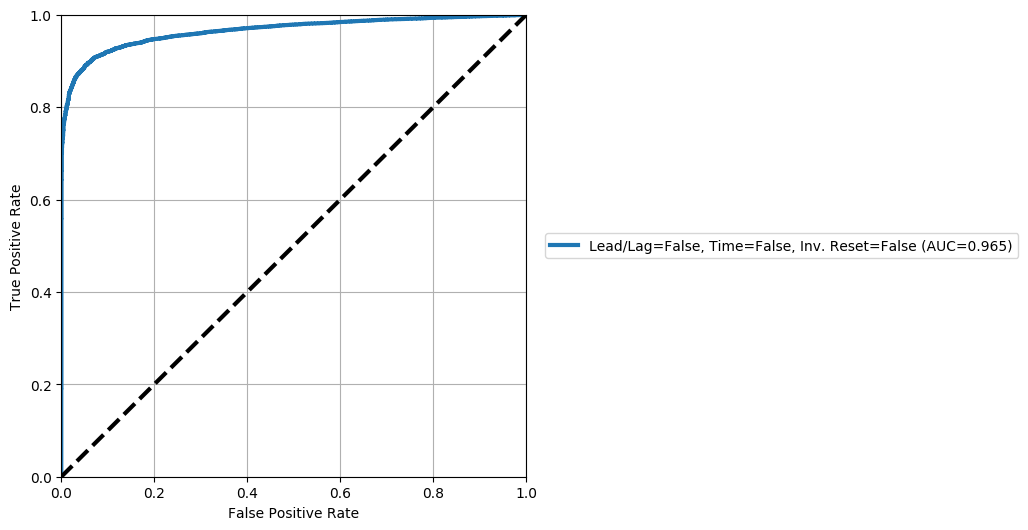

In [17]:
evaluation.plot_roc_curve(inliers, outliers)

Define a function which evaluates across a range of signature orders:

In [ ]:
%%time
def evaluate_across_hyperparams(outlier_detection_method=compute_stream_signature_variance_rp):
    variance_inliers_vs_hyperparams = {}
    variance_outliers_vs_hyperparams = {}

    for signature_order in range(1, 6):
        key = 'Signature order {}'.format(signature_order)
        variance_inliers_vs_hyperparams[key], variance_outliers_vs_hyperparams[key] = \
            evaluate(df, signature_order=signature_order, outlier_detection_method=outlier_detection_method)

    return variance_inliers_vs_hyperparams, variance_outliers_vs_hyperparams

variance_inliers_vs_hyperparams, variance_outliers_vs_hyperparams = evaluate_across_hyperparams()

Computing variances:  29%|██████████▍                         | 915/3163 [00:00<00:01, 1141.51it/s]

Plot ROC Curves across hyper-parameters:

Signature order 1


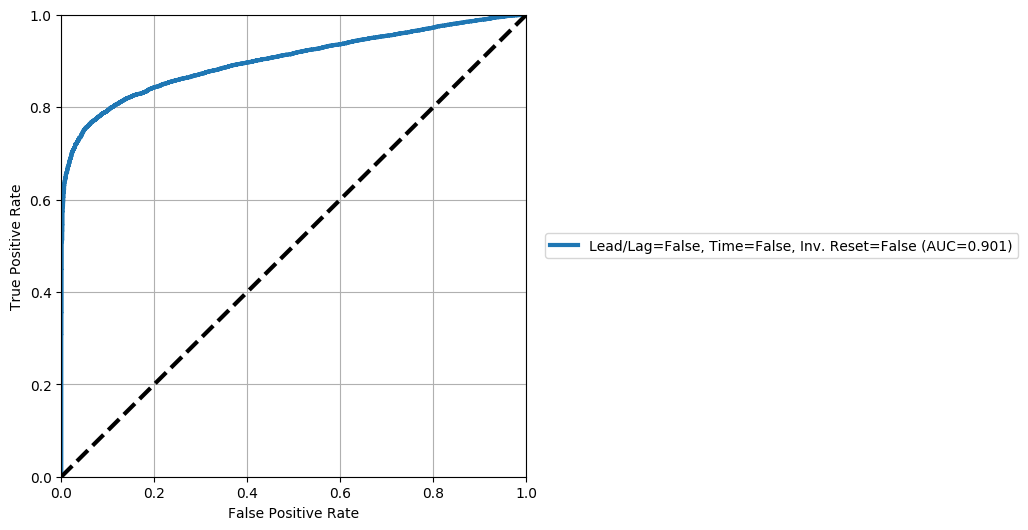

Signature order 2


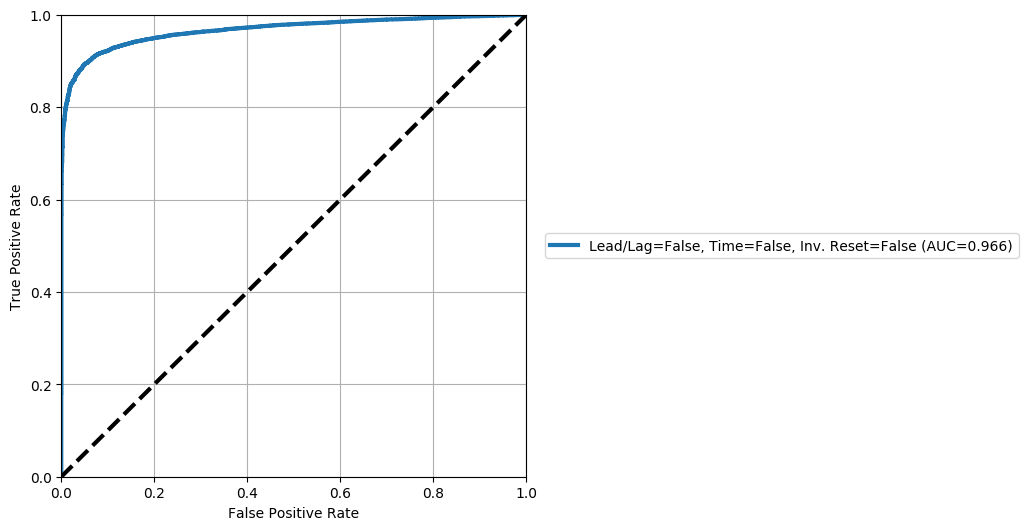

Signature order 3


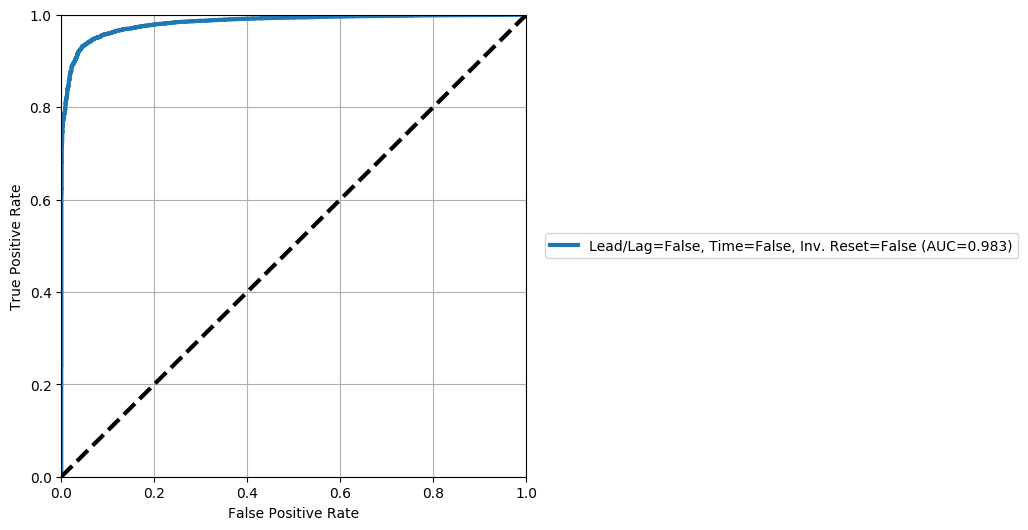

Signature order 4


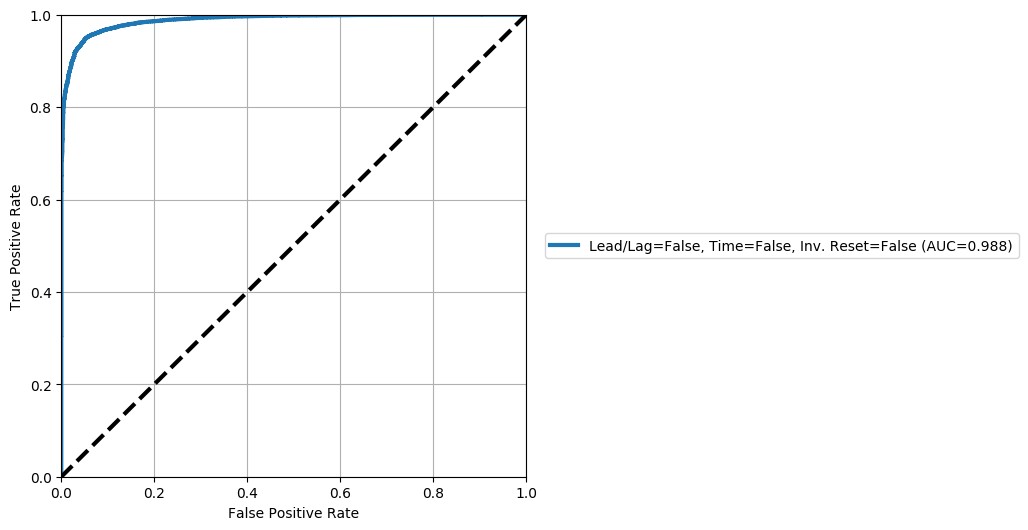

Signature order 5


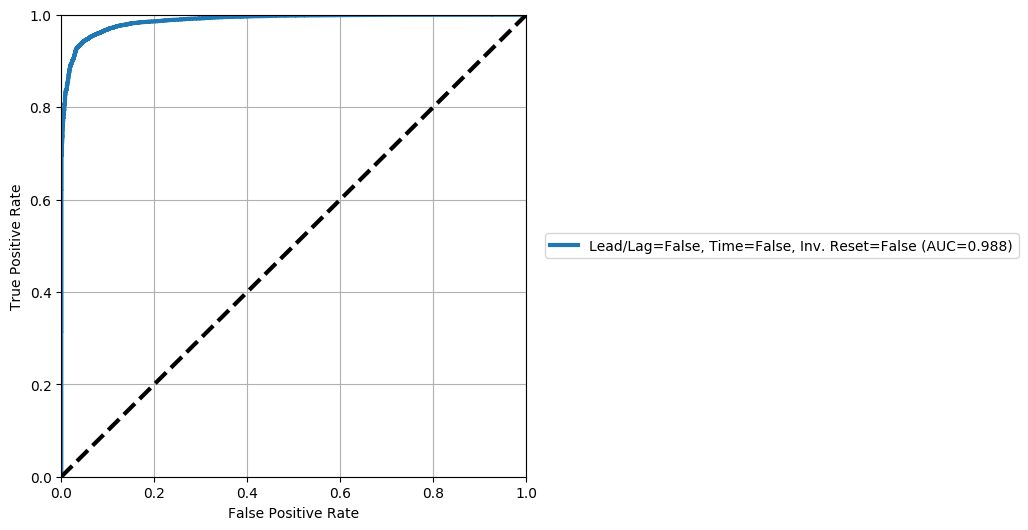

In [56]:
for key in variance_inliers_vs_hyperparams:
    print(key)
    evaluation.plot_roc_curve(variance_inliers_vs_hyperparams[key], variance_outliers_vs_hyperparams[key])

Tabulate AUC scores and bootstapped standard errors:

In [57]:
auc_vs_hyperparameters, standard_error_vs_hyperparameters = \
    evaluation.tabulate_performance(variance_inliers_vs_hyperparams, variance_outliers_vs_hyperparams)

In [58]:
auc_vs_hyperparameters

,Signature order 1,Signature order 2,Signature order 3,Signature order 4,Signature order 5
"Lead/Lag=False, Time=False, Inv. Reset=False",0.901,0.966,0.983,0.988,0.988


In [59]:
standard_error_vs_hyperparameters

,Signature order 1,Signature order 2,Signature order 3,Signature order 4,Signature order 5
"Lead/Lag=False, Time=False, Inv. Reset=False",0.003,0.001,0.001,0.001,0.000


Plot empirical cumulative distribution functions:

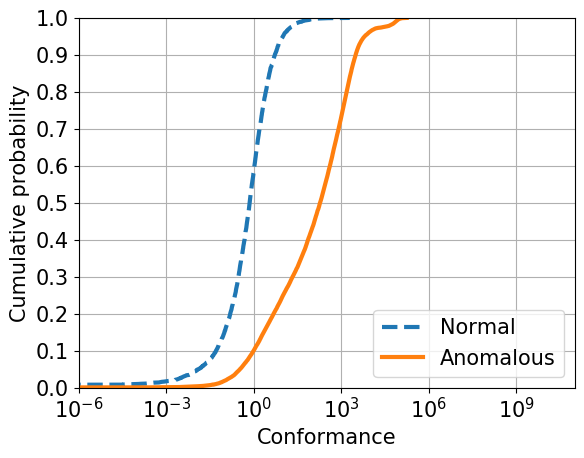

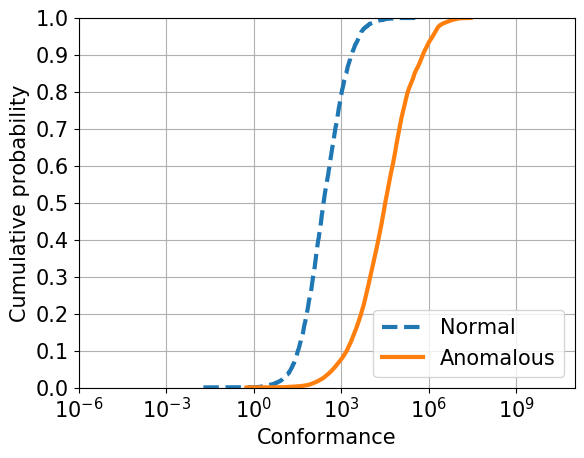

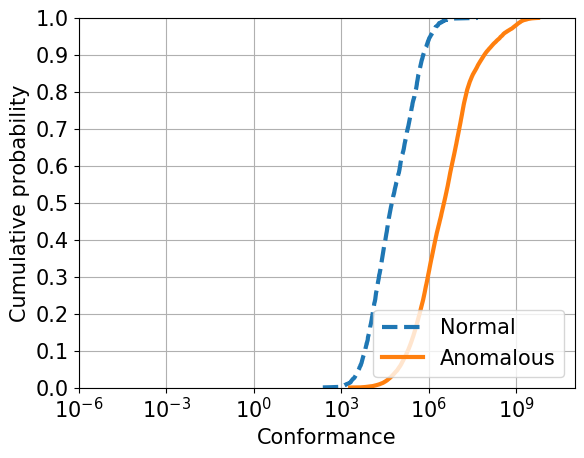

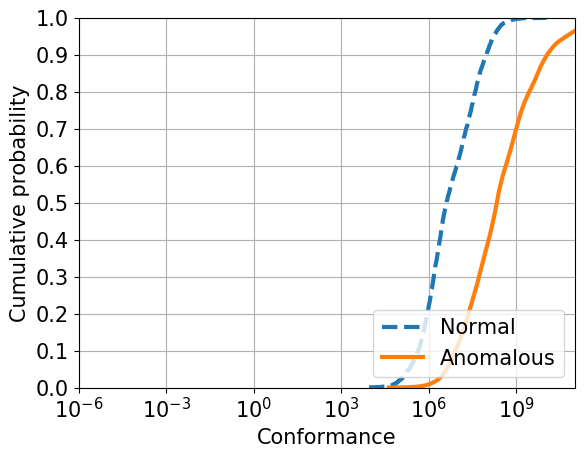

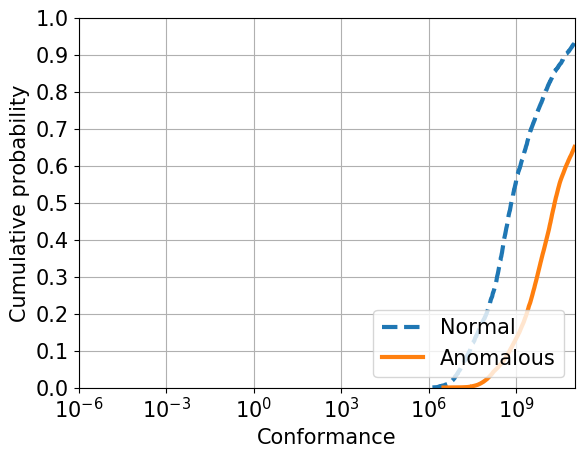

In [37]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

def plot_ecdf(variance_inliers, variance_outliers, lower_percentile=1, upper_percentile=100, fontsize=15):
    fig = plt.figure()
    
    xs, ys = ecdf(variance_inliers)
    plt.plot(xs, ys, label='Normal', linestyle='--', linewidth=3)
    xs, ys = ecdf(variance_outliers)
    plt.plot(xs, ys, label='Anomalous', linestyle='-', linewidth=3)
    plt.xscale('log')
    plt.xlabel('Conformance', fontsize=fontsize)
    plt.ylabel('Cumulative probability', fontsize=fontsize)
    plt.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.tick_params(axis='both', which='minor', labelsize=fontsize)
    
    # plt.xlim([min(np.percentile(variance_inliers, lower_percentile),
    #               np.percentile(variance_outliers, lower_percentile)),
    #           max(np.percentile(variance_inliers, upper_percentile),
    #               np.percentile(variance_outliers, upper_percentile))])
    plt.xlim([10**-6, 10**11])
    plt.yticks(np.linspace(0.0, 1.0, 11))
    plt.ylim([0.0, 1.0])
    
    plt.legend(loc='lower right', fontsize=fontsize)
    plt.grid()
    plt.show()
    
    return fig


key = 'Lead/Lag=False, Time=False, Inv. Reset=False'
for order in variance_inliers_vs_hyperparams.keys():
    fig = plot_ecdf(variance_inliers_vs_hyperparams[order][key],
                    variance_outliers_vs_hyperparams[order][key])
    fig.savefig('ecdf_order_{}.pdf'.format(order[-1]), bbox_inches='tight')

In [38]:
print('Execution time (s): {:.1f}'.format(time.time() - t0))

Execution time (s): 826.3
